In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time
from torch.utils.data import DataLoader, Dataset

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [4]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)
np.max(test_data)

Test data shape:  (4, 320, 256, 256)


1.0

In [5]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [6]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [7]:
def denoise(x_t, mask, y, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000):
    betas = torch.linspace(beta_min, beta_max, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for t in reversed(range(steps)):
        alpha_t_bar = alphas_cumprod[t]
        alpha_t_bar_prev =  alphas_cumprod[t-1]
        beta_t = betas[t]
        alpha_t = alphas[t]

        # Predict the noise using the model
        #with torch.no_grad():
        epsilon_theta = model(x_t)
    
        
        score_unconditional = -epsilon_theta/torch.sqrt(1-alpha_t_bar)
        x0_hat = 1/torch.sqrt(alpha_t_bar) * (x_t + (1-alpha_t_bar) * score_unconditional)
        
        A = mask * x0_hat
        difference = y - A
        loss = torch.linalg.norm(difference)
        likelihood_grad = torch.autograd.grad(loss, x_t)[0]

        if t > 1:
            mean =  (torch.sqrt(alpha_t) * (1-alpha_t_bar_prev))/(1 - alpha_t_bar) * x_t + (torch.sqrt(alpha_t_bar_prev) * beta_t)/(1 - alpha_t_bar) * x0_hat
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
            x_t -= step_size * likelihood_grad  

    return x0_hat



In [8]:
def denoise_dataloader(mask, y_dataloader, model, step_size, beta_min = 1e-4, beta_max = 0.02, steps=1000):
    images = []
    for i, y in enumerate(y_dataloader):
        print(i)
        x_t = torch.randn_like(y, requires_grad=True, dtype=torch.float32).to(device)
        y = y.detach().clone().to(device)
        generated_image = denoise(x_t, mask, y, model, step_size).reshape(-1,256,256).detach().cpu().numpy()
        images.append(generated_image)
    images = np.concatenate(images, axis=0)
    return images

In [9]:
class NumpyDataset(Dataset):
    def __init__(self, data):
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        #self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)

975.0
0
1
2


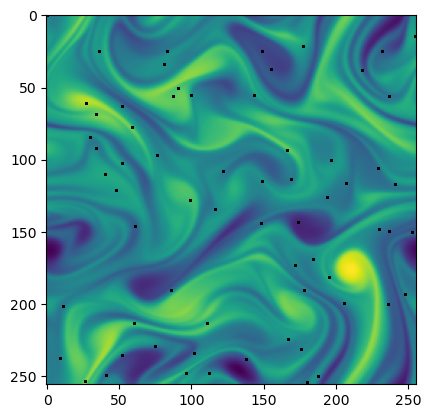

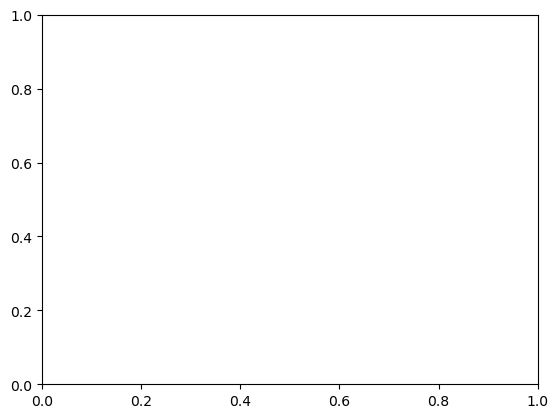

In [29]:
#Randomly choose a fixed percentage of points from the test snapshot
trajectory = 3
percentage = 0.1
factor = percentage/100
start_idx = 85
end_idx = 100
N = int(256**2 * factor)
test_snapshots = test_data[:, start_idx : end_idx]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshots[..., nx, ny]
plot_idx = 1
#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshots[trajectory, plot_idx].squeeze())
mask = np.zeros_like(test_snapshots[trajectory])
mask[..., nx, ny] = 1
print(np.sum(mask))
y = test_snapshots[trajectory] * mask
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
ax.scatter(xx*mask, yy*mask, s=1, c="black", alpha=0.5)

measurement_std = 0.0
measurement_noise = np.random.randn(*mask.shape) * measurement_std
y = y + measurement_noise * mask
y_dataset = NumpyDataset(y)
y_dataloader = DataLoader(y_dataset, batch_size=5, shuffle=False)

mask = torch.tensor(mask, requires_grad=True).to(device)
epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(1).to(device)

step_size= 0.0
generated_sample = denoise_dataloader(mask, y_dataloader, model, step_size)



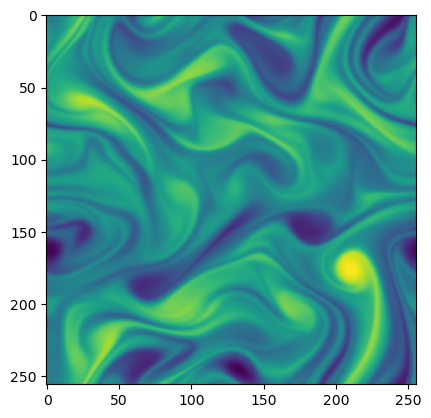

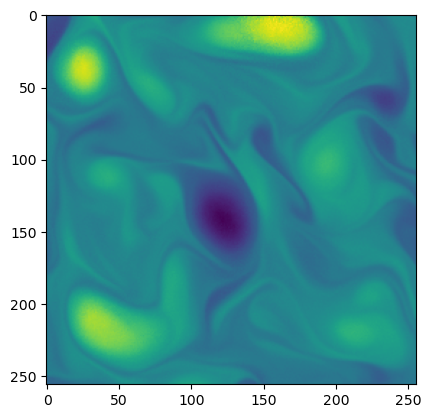

In [30]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
ax.imshow(test_snapshots[trajectory, plot_idx].squeeze())

ax2.imshow(generated_sample.squeeze()[plot_idx])

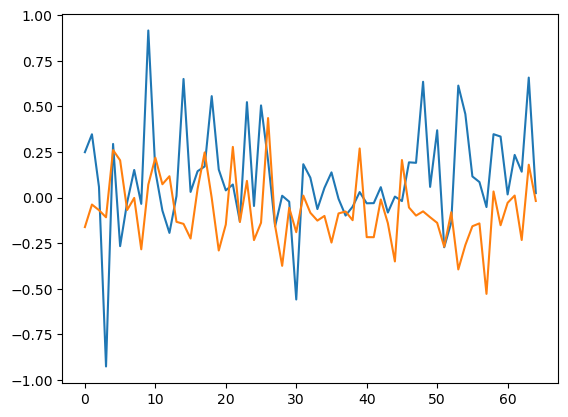

In [31]:
plt.plot(generated_sample.squeeze()[plot_idx, nx,ny])
plt.plot(test_snapshots.squeeze()[trajectory, plot_idx, nx,ny])

In [21]:
def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.var(field)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr

In [33]:
if step_size == 0:
    name = "unconditional" +  "_" + "p" + "_" + str(percentage)
else:
    name = "step_size_" + str(step_size) + "_" + "p" + "_" + str(percentage)
name = "generated_samples/" + name + ".npy"
np.save(name, generated_sample)


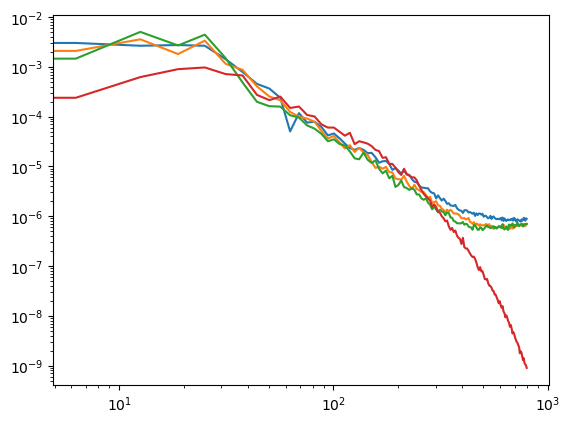

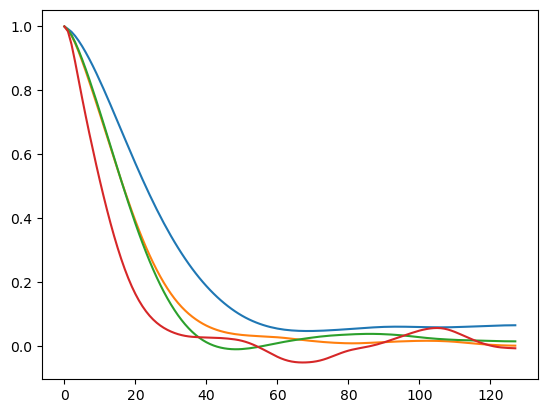

In [34]:
from energy_spectrum import compute_tke_spectrum
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()
names = ["unconditional_p_0.1", "step_size_0.6_p_0.1", "step_size_1.0_p_0.1"]
two_point_corrs = []
spectra = []
for name in names:
    generated_sample_numpy = np.load("generated_samples/" + name + ".npy")
    _, wavenumbers, spectrum = compute_tke_spectrum(generated_sample_numpy[plot_idx],1,1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    two_point_correlation = two_point_corr(generated_sample_numpy, axis=1)
    spectra.append(spectrum)
    two_point_corrs.append(two_point_correlation)
spectra = np.array(spectra)
two_point_corrs = np.array(two_point_corrs)

_, wavenumbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots.squeeze()[trajectory, plot_idx],1,1)
two_point_correlation_gt = two_point_corr(test_snapshots.squeeze()[trajectory], axis=1)

ax.plot(wavenumbers[:128], spectra.T[:128])
ax.plot(wavenumbers[:128], spectrum_ground_truth[:128])
fig

ax2.plot(two_point_corrs.T)
ax2.plot(two_point_correlation_gt)



In [457]:
ensemble_size = 100
ensemble_list = []

measurement_variance = 1
measurement_noise = torch.randn_like(mask, dtype=torch.float32) * measurement_variance
epsilon = torch.randn_like(mask, requires_grad=True, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device) + measurement_noise * mask
step_size= 0.6

for i in range(ensemble_size):
    print(i)
    generated_sample = denoise(epsilon, mask, y, model, step_size).squeeze().detach().cpu().numpy()
    ensemble_list.append(generated_sample[..., nx, ny])
ensemble = np.stack(ensemble_list)
ensemble_variance = np.var(ensemble, axis=0)
print(ensemble_variance)



/tmp/ipykernel_5286/3564674152.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device) + measurement_noise * mask


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[0.03884578 0.10400166 0.09126926 0.02921954 0.11650446 0.05814808
 0.08464799 0.01286905 0.0489191  0.07572212 0.3381551  0.13274528
 0.41584724 0.03258196 0.2057882  0.04401602 0.05347282 0.04426611
 0.04391261 0.28146732 0.07700738 0.00915764 0.07792924 0.09471689
 0.04579408 0.0416394  0.10406408 0.07470799 0.07098711 0.14788102
 0.1721527  0.0122054  0.22175957 0.10257802 0.26205006 0.04608531
 0.33802807 0.1505506  0.31046793 0.09341237 0.02136803 0.2943095
 0.13899252 0.02946016 0.05694793 0.26811898 0.08698405 0.07133022
 0.01908604 0.26815346 0.01879542 0.19406088 0.08662427 0.40604445
 0.15539698 0.10567565 0.08484864 0.02871813 0.5727308  0.05878666
 1.2050824  0.0573468  0.25446132 0.02921

In [36]:
print(ensemble.shape)
plt.plot(ensemble.T, color="0.8")
plt.plot(y[...,nx,ny].squeeze().detach().cpu().numpy())
np.mean(ensemble_variance)

NameError: name 'ensemble' is not defined